## Set Up Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## 1. Loading the dataframe 

In [ ]:
#from huggingface_hub import login
#login()

df = pd.read_parquet("hf://datasets/wstoloah/weld-quality-v1/data/train-00000-of-00001.parquet")

In [6]:
df

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,Charpy temperature / °C,Charpy impact toughness / J,Hardness / kgmm-2,50 % FATT,Primary ferrite in microstructure / %,Ferrite with second phase / %,Acicular ferrite / %,Martensite / %,Ferrite with carbide aggreagate / %,Weld ID
0,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.00,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.00,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32.0,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.100,0.35,0.90,0.008,0.016,0.60,8.6,0.98,0.18,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX35
1648,0.088,0.36,0.88,0.008,0.017,0.57,8.4,0.94,0.19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX36
1649,0.090,0.34,0.89,0.008,0.016,0.17,8.2,0.94,0.02,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX37
1650,0.092,0.35,0.90,0.008,0.016,0.54,8.4,0.97,0.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Birmingham-MAX38


#### 1.1 Distibutions 

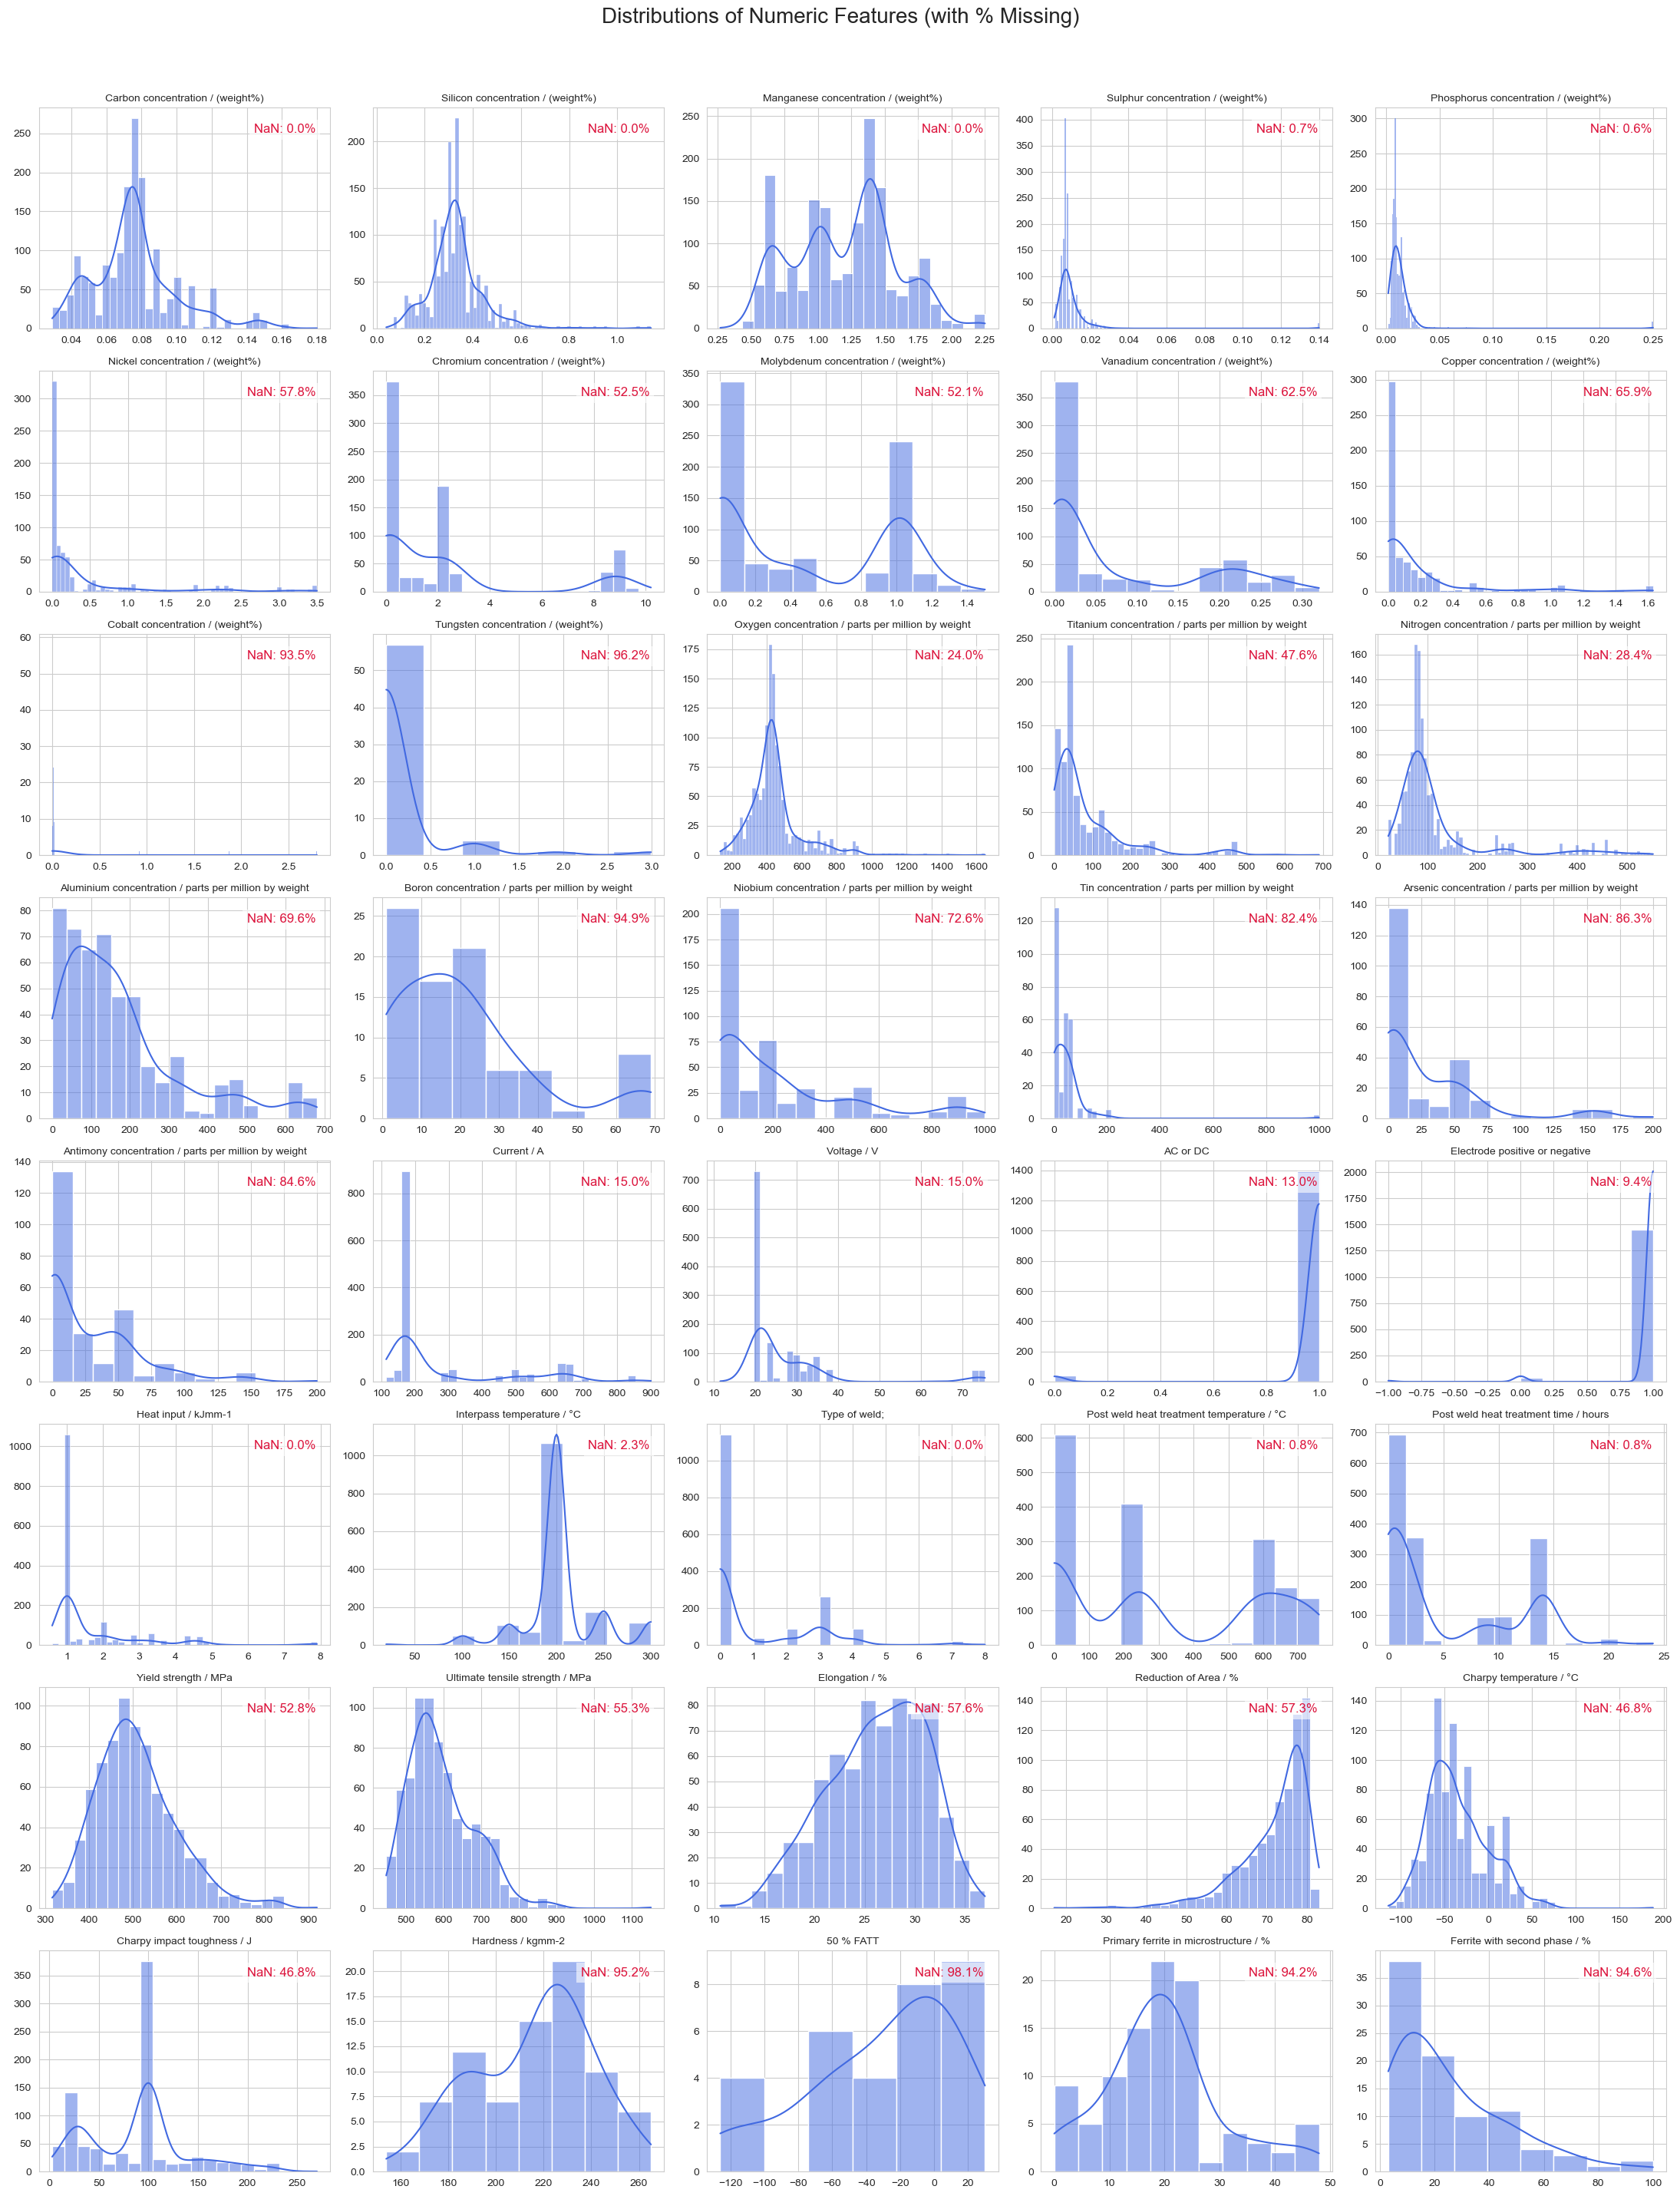

In [5]:
df_num = df
# Compute missing percentages 
missing_pct = df_num.isnull().mean() * 100  # %

# Plot setup 
sns.set_style("whitegrid")
n_cols = 5
n_rows = 8

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 28))
axes = axes.flatten()

# Loop over numeric columns
for i, col in enumerate(df_num.columns[:n_rows * n_cols]):
    sns.histplot(df_num[col], kde=True, color="royalblue", ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

    # Add missing value indicator (top-right corner)
    miss_text = f"NaN: {missing_pct[col]:.1f}%"
    axes[i].text(0.95, 0.9, miss_text,
                 transform=axes[i].transAxes,
                 ha="right", va="center",
                 fontsize=12,
                 color="crimson",
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# Hide unused subplots 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distributions of Numeric Features (with % Missing)", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

#### 1.2 Handling missing values before imputation

In [7]:
threshold = 0.6
df_num = df_num.loc[:, df_num.isnull().mean() < threshold]

In [8]:
df_num.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'AC or DC', 'Electrode positive or negative',
       'Heat input / kJmm-1', 'Interpass temperature / °C', 'Type of weld;',
       'Post weld heat treatment temperature / °C',
       'Post weld heat treatment time / hours', 'Yield strength / MPa',
       'Ultimate tensile strength / MPa', 'Elongation / %',
       'Reduction of Area / %', 'Charpy temperature / °C',
       'Charpy impact toughness / J', 'Weld ID'],
      dt

## 2. Define the target & Imputation

#### 2.1 Target definition

To model the quality of welding, we focus on these possible target variables because they directly represent the mechanical performance of the weld properties such as strength, ductility, and toughness that reflect overall weld quality.

In [9]:
# List of possible target columns (mechanical properties related to weld quality)
possible_targets = [
    'Yield strength / MPa',
    'Ultimate tensile strength / MPa',
    'Elongation / %',
    'Reduction of Area / %',
    'Charpy impact toughness / J'
]

# Describe these columns to understand their distributions
df_num[possible_targets].describe()

,Yield strength / MPa,Ultimate tensile strength / MPa,Elongation / %,Reduction of Area / %,Charpy impact toughness / J
count,780.000000,738.000000,700.000000,705.000000,879.00000
mean,508.557179,594.386314,26.275714,71.799858,87.68942
std,92.865446,88.636238,4.895986,8.926551,50.11670
min,315.000000,447.000000,10.600000,17.000000,3.00000
25%,443.000000,532.775000,22.800000,68.000000,38.00000
50%,495.000000,575.500000,26.800000,75.000000,100.00000
75%,559.250000,647.000000,30.000000,78.000000,100.00000
max,920.000000,1151.000000,37.000000,83.000000,270.00000


                                 Yield strength / MPa  \
Yield strength / MPa                         1.000000   
Ultimate tensile strength / MPa              0.915453   
Elongation / %                              -0.681018   
Reduction of Area / %                       -0.459835   
Charpy impact toughness / J                 -0.412386   

                                 Ultimate tensile strength / MPa  \
Yield strength / MPa                                    0.915453   
Ultimate tensile strength / MPa                         1.000000   
Elongation / %                                         -0.739141   
Reduction of Area / %                                  -0.661067   
Charpy impact toughness / J                            -0.701951   

                                 Elongation / %  Reduction of Area / %  \
Yield strength / MPa                  -0.681018              -0.459835   
Ultimate tensile strength / MPa       -0.739141              -0.661067   
Elongation / %            

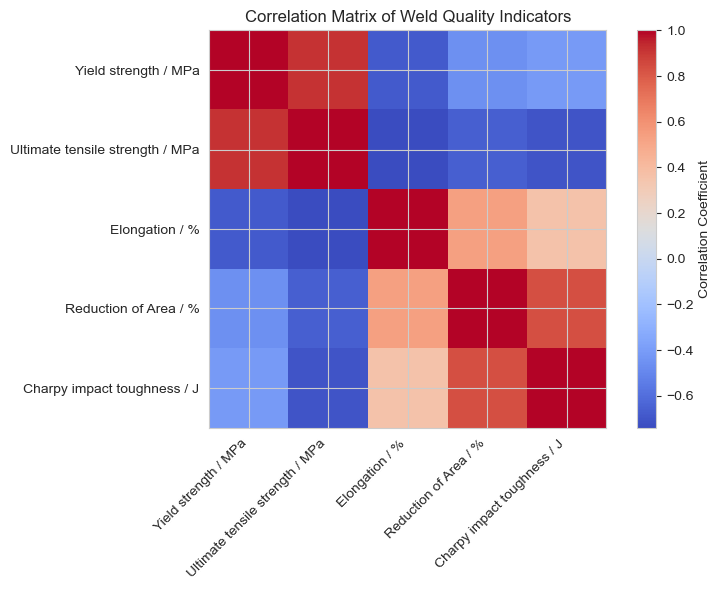

In [10]:
# Compute correlation matrix
corr_matrix = df_num[possible_targets].corr()
print(corr_matrix)

# Plot the correlation heatmap
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Correlation Matrix of Weld Quality Indicators')
plt.tight_layout()
plt.show()

Based on this correlation matrix, I selected Ultimate tensile strength / MPa as the target variable to represent weld quality because it is a direct measure of the weld’s ability to withstand applied loads before failure. It shows a very strong positive correlation with yield strength (0.91), indicating consistency with other strength indicators, while its inverse relationship with ductility and toughness reflects the fundamental strength–toughness trade-off. Therefore, it effectively captures the mechanical integrity of the weld as a single, continuous quality metric.


In [25]:
# Define the target variable
target = 'Yield strength / MPa'
# target vector
y = df_num[target]

# Define X (all other features, excluding target and identifiers, and highly correlated features with target)
X = df_num.drop(columns=[target, 'Weld ID', 'Ultimate tensile strength / MPa'])


#### 2.2 Split before imputation

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,  # ensures reproducibility
    shuffle=True       # this is True by default
)

In [27]:
X.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight', 'Current / A',
       'Voltage / V', 'AC or DC', 'Electrode positive or negative',
       'Heat input / kJmm-1', 'Interpass temperature / °C', 'Type of weld;',
       'Post weld heat treatment temperature / °C',
       'Post weld heat treatment time / hours', 'Elongation / %',
       'Reduction of Area / %', 'Charpy temperature / °C',
       'Charpy impact toughness / J'],
      dtype='object')

#### 2.3 Imputation


- Composition elements: Sulphur & Phosphorus: impute with mean (on train). All other composition elements: impute with 0 (assume “absent/undetected” default).
 
- Process variables (Current, Voltage, Heat input, Interpass temperature): median (robust to outliers).
 
- PWHT (temperature, time): set missing to 0 (represents “no PWHT”).
 
- Mechanical test variables (UTS, Elongation, Reduction of Area, Charpy temp & toughness): median 

In [28]:
composition_cols = [
    'Carbon concentration / (weight%)',
    'Silicon concentration / (weight%)',
    'Manganese concentration / (weight%)',
    'Sulphur concentration / (weight%)',
    'Phosphorus concentration / (weight%)',
    'Nickel concentration / (weight%)',
    'Chromium concentration / (weight%)',
    'Molybdenum concentration / (weight%)',
    'Oxygen concentration / parts per million by weight',
    'Titanium concentration / parts per million by weight',
    'Nitrogen concentration / parts per million by weight',
]
sp_cols = [c for c in composition_cols if c in ['Sulphur concentration / (weight%)','Phosphorus concentration / (weight%)']]
other_comp_cols = [c for c in composition_cols if c not in sp_cols]

process_cols = [c for c in [
    'Current / A', 'Voltage / V', 'Heat input / kJmm-1', 'Interpass temperature / °C'
] if c in X.columns]

pwht_cols = [c for c in [
    'Post weld heat treatment temperature / °C', 'Post weld heat treatment time / hours'
] if c in X.columns]

# detect already one-hot columns in X (0/1 dummies)
def is_dummy(col_series):
    vals = pd.Series(col_series).dropna().unique()
    return set(vals).issubset({0, 1})

ohe_cols = [c for c in X.columns if is_dummy(X[c])]


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# imputers 
sp_imputer         = Pipeline([('imp', SimpleImputer(strategy='mean'))])                    # S, P → mean
other_comp_imputer = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value=0))])  # other composition → 0
proc_imputer       = Pipeline([('imp', SimpleImputer(strategy='median'))])                  # process → median
pwht_imputer       = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value=0))])  # PWHT → 0
ohe_imputer        = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value=0))])  # OHE dummies → 0

# build ColumnTransformer 
preprocess = ColumnTransformer(
    transformers=[
        ('sp',          sp_imputer,         sp_cols),
        ('other_comp',  other_comp_imputer, other_comp_cols),
        ('process',     proc_imputer,       process_cols),
        ('pwht',        pwht_imputer,       pwht_cols),
        ('ohe',         ohe_imputer,        ohe_cols),
    ],
    remainder='drop'  # change to 'passthrough' if you expect other clean numeric cols you want to keep
)

# fit on TRAIN only, transform both
X_train = preprocess.fit_transform(X_train)
X_test  = preprocess.transform(X_test)


In [31]:
X_train.shape
#y_train.shape

(1321, 18)

## 3. PCA

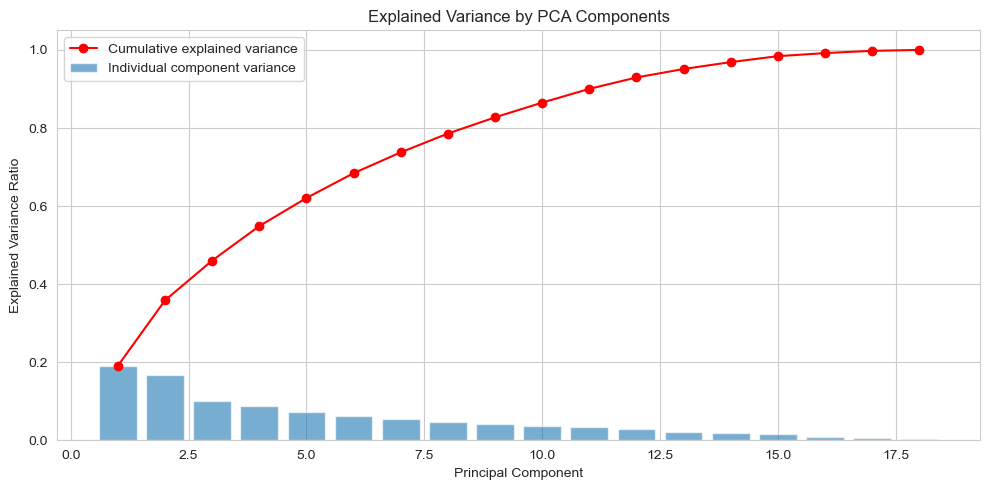

Number of components explaining ≥95% variance: 13


In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Standardize the features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Fit PCA (keep all components initially)
pca = PCA()
pca.fit(X_train_scaled)

#  Extract explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

#  Plot variance per component
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Individual component variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='red', label='Cumulative explained variance')

plt.title('Explained Variance by PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#components explain 95% of variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining ≥95% variance: {n_components_95}")

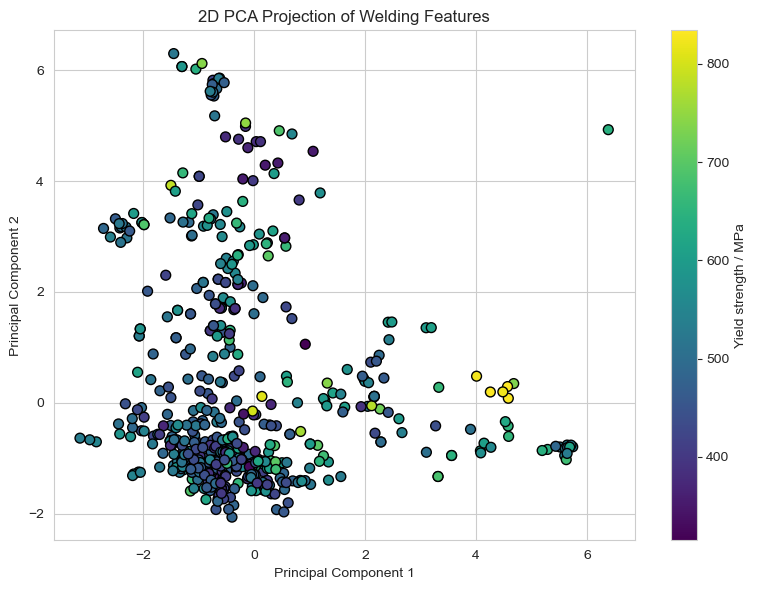

In [34]:
from mpl_toolkits.mplot3d import Axes3D  # for 3D plot


# Standardize (fit only on train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Fit PCA for 2 and 3 components
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

pca_3d = PCA(n_components=3)
X_train_pca_3d = pca_3d.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sc = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1],
                 c=y_train, cmap='viridis', s=50, edgecolor='k')
plt.colorbar(sc, label='Yield strength / MPa')
plt.title('2D PCA Projection of Welding Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. SemiSupervised appraoch

#### 4.1 Visualize the target 

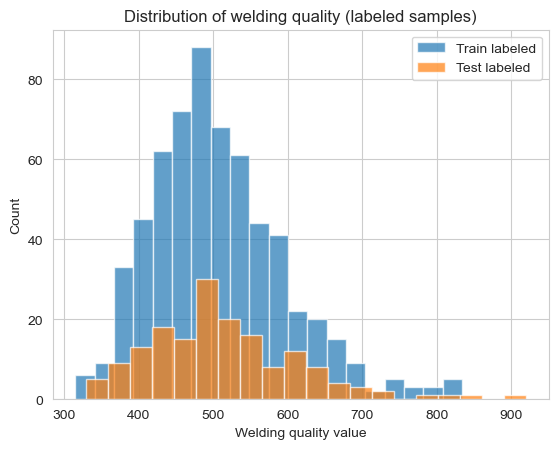

Labeled samples in train: 613 / 1321
Labeled samples in test:  167 / 331


In [36]:
# Separate labeled vs unlabeled
y_train_labeled = y_train.dropna()
y_test_labeled  = y_test.dropna()

# Plot distributions
plt.figure()
plt.hist(y_train_labeled, bins=20, alpha=0.7, label="Train labeled")
plt.hist(y_test_labeled,  bins=20, alpha=0.7, label="Test labeled")
plt.legend()
plt.xlabel("Welding quality value")
plt.ylabel("Count")
plt.title("Distribution of welding quality (labeled samples)")
plt.show()

# Show how much is missing
print(f"Labeled samples in train: {y_train_labeled.shape[0]} / {y_train.shape[0]}")
print(f"Labeled samples in test:  {y_test_labeled.shape[0]} / {y_test.shape[0]}")

Compute quantiles to define the threshold

In [37]:
# Compute quantile cutoffs
q_low, q_mid = y_train_labeled.quantile([0.33, 0.66])

print(f"Cutoffs: low < {q_low:.1f}, mid < {q_mid:.1f}, high ≥ {q_mid:.1f}")

def quality_class(y):
    if np.isnan(y): return np.nan
    elif y < q_low: return 0   # low quality
    elif y < q_mid: return 1   # medium
    else: return 2             # high quality

y_train_class = y_train.apply(quality_class)
y_test_class  = y_test.apply(quality_class)


Cutoffs: low < 463.0, mid < 530.9, high ≥ 530.9


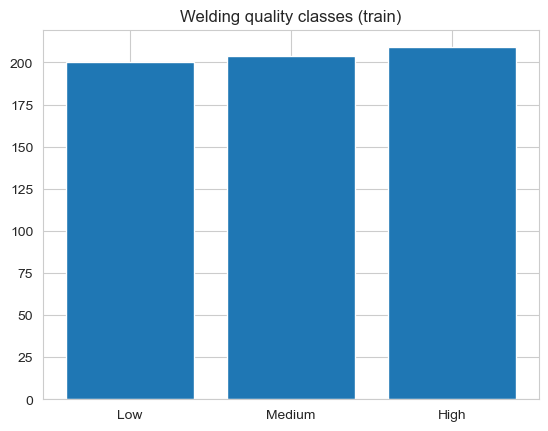

In [38]:
plt.hist(y_train_class.dropna(), bins=[-0.5,0.5,1.5,2.5], rwidth=0.8)
plt.xticks([0,1,2], ["Low","Medium","High"])
plt.title("Welding quality classes (train)")
plt.show()

In [40]:
y_train_class

306     NaN
192     2.0
309     0.0
1360    NaN
63      0.0
       ... 
1130    2.0
1294    NaN
860     NaN
1459    0.0
1126    1.0
Name: Yield strength / MPa, Length: 1321, dtype: float64

#### 4.2 Semi Supervised methods 

Semi-supervised learning is useful when we have **some labeled data** and **a large amount of unlabeled data**.  
Instead of discarding the unlabeled samples, we can use them to improve learning by propagating label information through a similarity graph.

Scikit-learn provides two powerful graph-based semi-supervised algorithms:

| Algorithm | Description | Key Parameter | Behavior |
|------------|--------------|----------------|-----------|
| **LabelPropagation** | Directly propagates labels through the graph built from feature similarity. | `gamma` (for RBF kernel) | Fast, can overfit noisy labels. |
| **LabelSpreading** | A regularized version of LabelPropagation that smooths labels during propagation. | `gamma`, `alpha` | More stable, better for noisy data. |


###### 4.2.1 Label Spreading

In [42]:
X_train_scaled.shape

(1321, 18)

In [ ]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Masks
train_unlabeled_mask = y_train_class.isna()
test_labeled_mask    = ~y_test_class.isna()   # only these rows can be evaluated


# Prepare semi-supervised labels (-1 = unlabeled)
y_train_semi = y_train_class.copy()
y_train_semi[train_unlabeled_mask] = -1
y_train_semi = y_train_semi.astype(int)  # LabelSpreading expects ints

#  Train
model = LabelSpreading(kernel='rbf', gamma=0.25, alpha=0.2, max_iter=30)
model.fit(X_train_scaled, y_train_semi)

# --- Predict on the whole test set (ok), but evaluate only where y_test is known
y_pred_full = model.predict(X_test_scaled)

y_true_eval = y_test_class[test_labeled_mask].astype(int)
y_pred_eval = y_pred_full[test_labeled_mask.values]  # align by the same mask

print(classification_report(y_true_eval, y_pred_eval, target_names=['Low','Medium','High']))
print("Confusion matrix:\n", confusion_matrix(y_true_eval, y_pred_eval))



<Figure size 600x500 with 0 Axes>

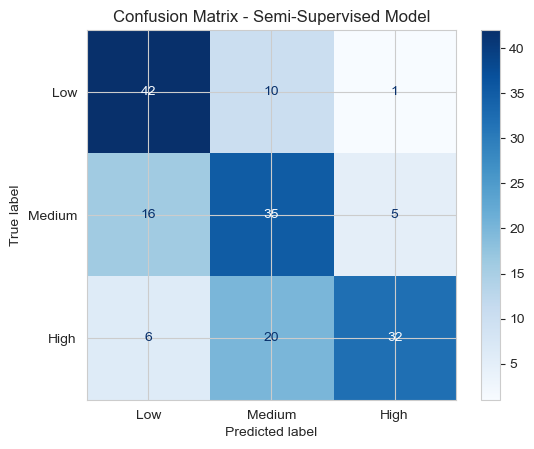

In [48]:
cm = confusion_matrix(y_true_eval, y_pred_eval)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Semi-Supervised Model")
plt.show()

###### 4.2.2 Label Propagation

=== LabelPropagation ===
              precision    recall  f1-score   support

         Low       0.66      0.75      0.70        53
      Medium       0.54      0.64      0.59        56
        High       0.85      0.57      0.68        58

    accuracy                           0.65       167
   macro avg       0.68      0.66      0.66       167
weighted avg       0.68      0.65      0.66       167

Confusion matrix:
 [[40 12  1]
 [15 36  5]
 [ 6 19 33]]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\semi_supervised\_label_propagation.py:322: ConvergenceWarning: max_iter=30 was reached without convergence.
  warnings.warn(


<Figure size 600x500 with 0 Axes>

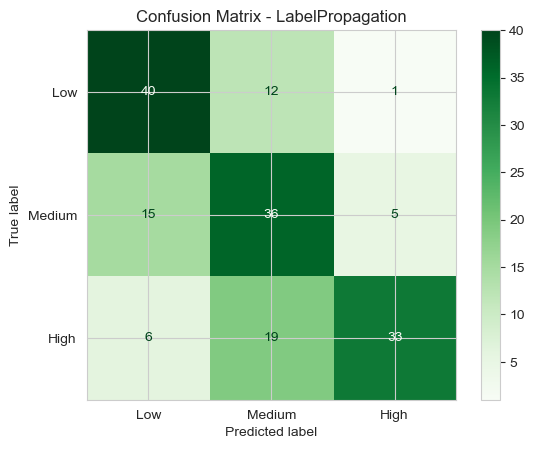

In [ ]:
from sklearn.semi_supervised import LabelPropagation
# Masks
train_unlabeled_mask = y_train_class.isna()
test_labeled_mask    = ~y_test_class.isna()   # only these rows can be evaluated

# Prepare semi-supervised labels (-1 = unlabeled)
y_train_semi = y_train_class.copy()
y_train_semi[train_unlabeled_mask] = -1
y_train_semi = y_train_semi.astype(int)  # LabelPropagation expects ints

# Train LabelPropagation model
model = LabelPropagation(kernel='rbf', gamma=0.25, max_iter=30)
model.fit(X_train_scaled, y_train_semi)

#  Predict
y_pred_full = model.predict(X_test_scaled)

# Evaluate only on labeled test samples
y_true_eval = y_test_class[test_labeled_mask].astype(int)
y_pred_eval = y_pred_full[test_labeled_mask.values]  # align by the same mask

# Metrics
print("=== LabelPropagation ===")
print(classification_report(y_true_eval, y_pred_eval, target_names=['Low','Medium','High']))
print("Confusion matrix:\n", confusion_matrix(y_true_eval, y_pred_eval))

#  Plot confusion matrix
cm = confusion_matrix(y_true_eval, y_pred_eval)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(6, 5))
disp.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - LabelPropagation")
plt.show()


###### 4.2.3 Self-Training (Wrapper-based Semi-Supervised)

End of iteration 1, added 263 new labels.
End of iteration 2, added 56 new labels.
End of iteration 3, added 13 new labels.
End of iteration 4, added 30 new labels.
End of iteration 5, added 14 new labels.
End of iteration 6, added 2 new labels.
End of iteration 7, added 3 new labels.
End of iteration 8, added 6 new labels.
End of iteration 9, added 6 new labels.
End of iteration 10, added 6 new labels.
=== Self-Training (Random Forest) ===
              precision    recall  f1-score   support

         Low       0.72      0.89      0.80        53
      Medium       0.67      0.55      0.61        56
        High       0.82      0.79      0.81        58

    accuracy                           0.74       167
   macro avg       0.74      0.74      0.74       167
weighted avg       0.74      0.74      0.74       167



<Figure size 600x500 with 0 Axes>

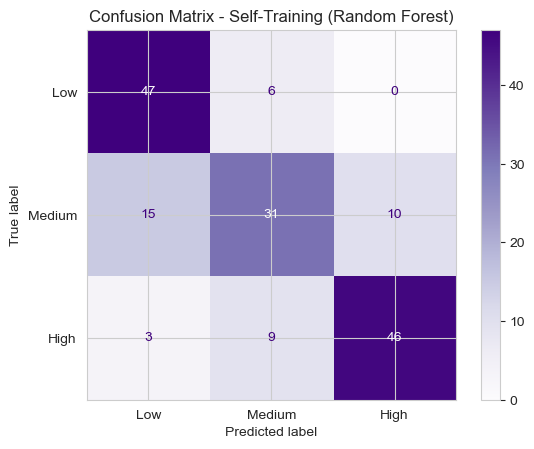

In [50]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier


# Masks
train_unlabeled_mask = y_train_class.isna()
test_labeled_mask    = ~y_test_class.isna()   # only labeled samples used for evaluation

# Prepare semi-supervised labels (-1 = unlabeled)
y_train_semi = y_train_class.copy()
y_train_semi[train_unlabeled_mask] = -1
y_train_semi = y_train_semi.astype(int)

# Define base model and SelfTraining wrapper
base_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1
)

self_training = SelfTrainingClassifier(
    base_model,
    threshold=0.8,       # confidence threshold for pseudo-labeling
    max_iter=10,         # max self-training iterations
    verbose=True
)

#  Train model
self_training.fit(X_train_scaled, y_train_semi)

#  Predict
y_pred_full = self_training.predict(X_test_scaled)

#  Evaluate only on labeled test data
y_true_eval = y_test_class[test_labeled_mask].astype(int)
y_pred_eval = y_pred_full[test_labeled_mask.values]

print("=== Self-Training (Random Forest) ===")
print(classification_report(y_true_eval, y_pred_eval, target_names=['Low','Medium','High']))

# Confusion matrix
cm = confusion_matrix(y_true_eval, y_pred_eval)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Purples', values_format='d')
plt.title("Confusion Matrix - Self-Training (Random Forest)")
plt.show()
